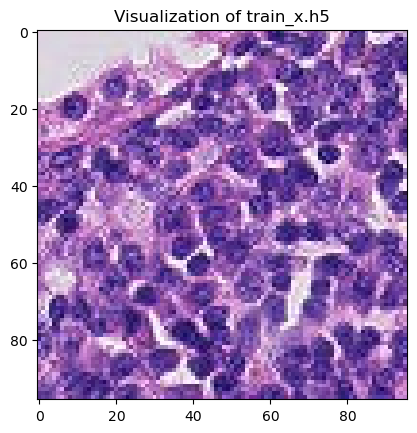

In [1]:
import os
import h5py
import matplotlib.pyplot as plt


folder_path = '/Users/ramsesnestor/Desktop/data'


file_to_dataset = {
    'train_x.h5': 'x',
    'train_y.h5': 'y',
    'valid_x.h5': 'x',
    'valid_y.h5': 'y',
    'test_x.h5': 'x',
    'test_y.h5': 'y'
}


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
       
        dataset = file[dataset_name]
        
        
        data = dataset[:]
        
 
        
      
        if 'train_x.h5' in filename:
            plt.imshow(data[0], cmap='gray')  
            plt.title(f'Visualization of {filename}')
            plt.show()


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential

from keras.optimizers import Adagrad
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import uniform, randint

from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from hyperopt import fmin, tpe, hp, Trials

from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = None, None, None, None, None, None


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
        
        dataset = file[dataset_name]
        
        
        if 'train_x.h5' in filename:
            x_train = dataset[:]
        elif 'train_y.h5' in filename:
            y_train = dataset[:]
        elif 'valid_x.h5' in filename:
            x_valid = dataset[:]
        elif 'valid_y.h5' in filename:
            y_valid = dataset[:]
        elif 'test_x.h5' in filename:
            x_test = dataset[:]
        elif 'test_y.h5' in filename:
            y_test = dataset[:]

In [4]:
len(x_train), len(y_train), len(x_valid), len(y_valid), len(x_test), len(y_test)

(262144, 262144, 32768, 32768, 32768, 32768)

In [5]:
#checking for class imbalance

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for i, class_count in enumerate(class_counts):
    class_name = unique_classes[i]
    print(f"Class {class_name}: {class_count} samples")


Class 0: 131072 samples
Class 1: 131072 samples


In [6]:
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
x_train_resized = x_train.reshape(x_train.shape[0], 96, 96, 3)
x_valid_resized = x_valid.reshape(x_valid.shape[0], 96, 96, 3)
x_test_resized = x_test.reshape(x_test.shape[0], 96, 96, 3)


In [8]:


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(x_train_resized)

In [9]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

# Simple

In [17]:

model_1 = Sequential([
    Flatten(input_shape=(96, 96, 3)),  
    Dense(128, activation='relu', kernel_regularizer='l2'), 
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Summarize the model architecture
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 27648)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               3539072   
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,539,713
Trainable params: 3,539,457
Non-trainable params: 256
__________________________________________

In [18]:
history_1 = model_1.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                        validation_data=(x_valid_resized, y_valid),
                    
                     steps_per_epoch=len(x_train_resized)/16, epochs=10)

Epoch 1/10


2023-09-21 15:28:03.507688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16383/16384 [============================>.] - ETA: 0s - loss: 0.8704 - accuracy: 0.5651 - precision: 0.5617 - recall: 0.5926 - auc: 0.5931

2023-09-21 15:32:55.204320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 299s 18ms/step - loss: 0.8704 - accuracy: 0.5651 - precision: 0.5617 - recall: 0.5926 - auc: 0.5932 - val_loss: 0.9199 - val_accuracy: 0.4985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5829
Epoch 2/10
16384/16384 [==============================] - 375s 23ms/step - loss: 0.7966 - accuracy: 0.5576 - precision: 0.5544 - recall: 0.5871 - auc: 0.5852 - val_loss: 0.7717 - val_accuracy: 0.6588 - val_precision: 0.6058 - val_recall: 0.9074 - val_auc: 0.5970
Epoch 3/10
16384/16384 [==============================] - 315s 19ms/step - loss: 0.7847 - accuracy: 0.5424 - precision: 0.5401 - recall: 0.5711 - auc: 0.5620 - val_loss: 0.8998 - val_accuracy: 0.4995 - val_precision: 0.4995 - val_recall: 1.0000 - val_auc: 0.5506
Epoch 4/10
16384/16384 [==============================] - 318s 19ms/step - loss: 0.7694 - accuracy: 0.5425 - precision: 0.5393 - recall: 0.5830 - auc: 0.5605 - val_loss: 0.7687 - val_accuracy: 0.4995 - val_precisio

In [19]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_1.history['recall'], label='Training Recall')
plt.plot(history_1.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Dense

In [20]:
model_2 = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(512, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(2048, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

model_2.summary()

In [ ]:
history_2 = model_2.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                        validation_data=(x_valid_resized, y_valid),
                    
                     steps_per_epoch=len(x_train_resized)/16, epochs=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_2.history['recall'], label='Training Recall')
plt.plot(history_2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# CNN 1

In [31]:

model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.002674898810048853)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.002674898810048853)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.002674898810048853)))
model_cnn.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.5012121580601727))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
optimizer=Adagrad(learning_rate=0.01)
model_cnn.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 47, 47, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 45, 45, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 20, 256)       147712    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 10, 10, 256)    

In [32]:
history_cnn = model_cnn.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                        validation_data=(x_valid_resized, y_valid),
                         steps_per_epoch=len(x_train_resized)/16, epochs=10)

Epoch 1/10


2023-09-20 18:23:01.437280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16382/16384 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.7954 - recall: 0.7957

2023-09-20 18:29:21.307193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 389s 24ms/step - loss: 0.6704 - accuracy: 0.7954 - recall: 0.7957 - val_loss: 0.9587 - val_accuracy: 0.5741 - val_recall: 0.1573
Epoch 2/10
16384/16384 [==============================] - 385s 23ms/step - loss: 0.4031 - accuracy: 0.8339 - recall: 0.8372 - val_loss: 0.7372 - val_accuracy: 0.6604 - val_recall: 0.3598
Epoch 3/10
 2686/16384 [===>..........................] - ETA: 4:04 - loss: 0.3840 - accuracy: 0.8447 - recall: 0.8459

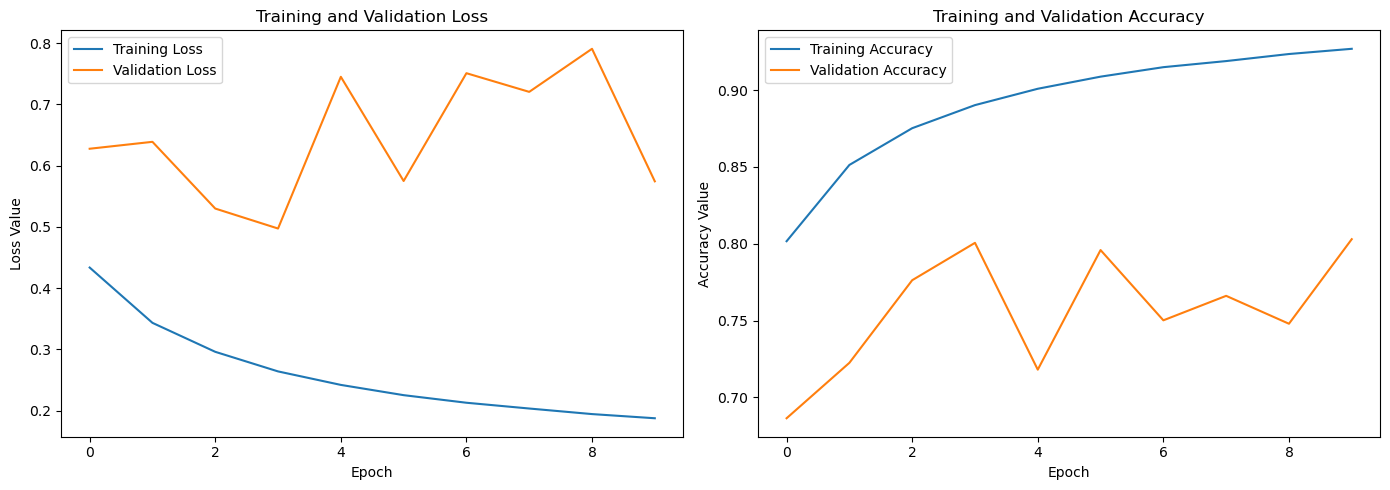

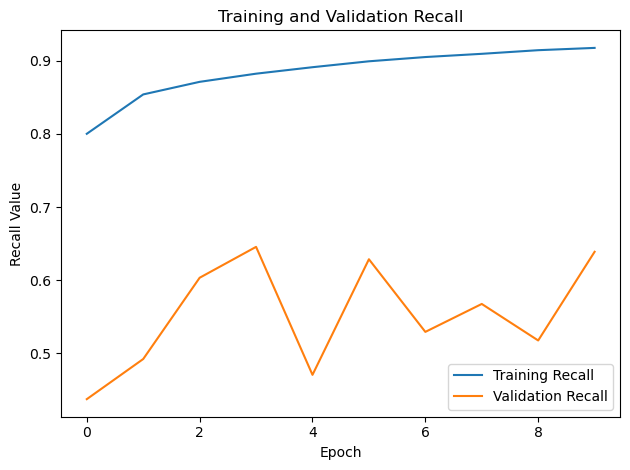

In [15]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn.history['recall'], label='Training Recall')
plt.plot(history_cnn.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the testing data
test_loss, test_accuracy, test_recall = model_cnn.evaluate(x_test_resized, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)


1024/1024 [==============================] - 10s 9ms/step - loss: 0.8465 - accuracy: 0.7428 - recall: 0.5125
Test Loss: 0.8465027809143066
Test Accuracy: 0.742767333984375
Test Recall: 0.5124870538711548


# CNN2 SGD optimizer

In [ ]:
model_cnn2 = Sequential() #sgd optimizer

# Convolutional layers
model_cnn2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))
model_cnn2.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn2.summary()

In [ ]:
history_cnn2 = model_cnn2.fit(datagen.flow(x_train_final, y_train_final, batch_size=16), 
                                    validation_data=(x_val_final, y_val_final),
                                    steps_per_epoch=len(x_train_final)/16, epochs=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['loss'], label='Training Loss')
plt.plot(history_cnn2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history_cnn2.history['recall'], label='Training Recall')
plt.plot(history_cnn2.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Similar performance with sgd

In [10]:


subset_size = 1000

x_train_subset, _, y_train_subset, _ = train_test_split(
    x_train_resized, y_train, stratify=y_train, train_size=subset_size)

In [ ]:
#looking for best optimizer (adagrad)

def create_model(optimizer="adam"):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    return model

# create model
model = KerasClassifier(model=create_model, epochs=10, batch_size=16, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train_resized, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [12]:
#looking for best learning rate (0.01)

def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adagrad(learning_rate=learning_rate)  
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'learning_rate': [0.01, 0.1, 0.001]}  

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(x_train_subset, y_train_subset)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/var/folders/r8/hd_vlpfn6vzgzp058w0l7w3r0000gn/T/ipykernel_2154/2772305936.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)
2023-09-20 16:50:04.880292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-20 16:50:04.880293: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-20 16:50:04.880293: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-20 16:50:04.880293: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-20 16:50:04.880314: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-20 16:50:04.880295: W tensorflow/core/platform/profi

Metal device set to: Apple M2 Max
Metal device set to: Apple M2 Max
Metal device set to: Apple M2 Max


2023-09-20 16:50:08.824629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-20 16:50:08.824629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-20 16:50:08.824817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-20 16:50:08.824822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M2 Max


2023-09-20 16:50:11.138151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Best: 0.557063 using {'learning_rate': 0.01}


In [14]:
# random search (not very helpful)

def create_model(filters1=64, filters2=64, filters3=256, filters4=256, dense_units=512, dropout_rate=0.5, learning_rate=0.01, weight_decay=0.001):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(filters1, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters2, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters3, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters4, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D(2, 2))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adagrad(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    
    return model

param_dist = {
    'filters1': randint(32, 128),
    'filters2': randint(64, 256),
    'filters3': randint(128, 512),
    'filters4': randint(256, 1024),
    'dense_units': randint(256, 1024),
    'dropout_rate': uniform(0.3, 0.7),
    'learning_rate': uniform(0.001, 0.1),
    'weight_decay': uniform(0.001, 0.1)
}

# Create your Keras classifier
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16, verbose=0)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='recall', cv=3, verbose=2, n_jobs=-1)

random_search.fit(x_train_subset, y_train_subset)

print("Best parameters found: ", random_search.best_params_)
print("Best recall: {:.4f}".format(random_search.best_score_))


/var/folders/r8/hd_vlpfn6vzgzp058w0l7w3r0000gn/T/ipykernel_2209/3873147273.py:51: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2023-09-20 13:20:58.940716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.320704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.344923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.643118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.718930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.719573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:20:59.766120: I tensorflow/core/grappler/optimizers/cust

[CV] END dense_units=713, dropout_rate=0.8696730732986293, filters1=126, filters2=210, filters3=286, filters4=722, learning_rate=0.08255450067380696, weight_decay=0.02342704078122534; total time=  57.9s
11/11 [==============================] - 2s 92ms/step


2023-09-20 13:22:04.315233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=378, dropout_rate=0.5012121580601727, filters1=108, filters2=177, filters3=199, filters4=878, learning_rate=0.06516691237683736, weight_decay=0.002674898810048853; total time= 1.7min
 1/11 [=>............................] - ETA: 5s

2023-09-20 13:22:04.984772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/11 [=======>......................] - ETA: 1s

2023-09-20 13:22:05.385228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 70ms/step


2023-09-20 13:22:07.699832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:08.116788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:09.167437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=999, dropout_rate=0.3030216168261201, filters1=118, filters2=85, filters3=306, filters4=349, learning_rate=0.06564041592090683, weight_decay=0.03897842887964142; total time= 1.4min
10/11 [==========================>...] - ETA: 0s

2023-09-20 13:22:10.580316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 125ms/step
[CV] END dense_units=625, dropout_rate=0.9815386895613809, filters1=87, filters2=152, filters3=206, filters4=563, learning_rate=0.09531517628244746, weight_decay=0.03195875469059613; total time=  48.0s
11/11 [==============================] - 1s 77ms/step


2023-09-20 13:22:13.958496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=713, dropout_rate=0.8696730732986293, filters1=126, filters2=210, filters3=286, filters4=722, learning_rate=0.08255450067380696, weight_decay=0.02342704078122534; total time= 1.0min
11/11 [==============================] - 1s 66ms/step


2023-09-20 13:22:23.719936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:23.899860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:26.559676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:28.215493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:28.257529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=625, dropout_rate=0.9815386895613809, filters1=87, filters2=152, filters3=206, filters4=563, learning_rate=0.09531517628244746, weight_decay=0.03195875469059613; total time=  48.1s
10/11 [==========================>...] - ETA: 0s

2023-09-20 13:22:29.209143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 75ms/step
[CV] END dense_units=625, dropout_rate=0.9815386895613809, filters1=87, filters2=152, filters3=206, filters4=563, learning_rate=0.09531517628244746, weight_decay=0.03195875469059613; total time=  49.6s
 4/11 [=========>....................] - ETA: 0s

2023-09-20 13:22:30.863501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 166ms/step


2023-09-20 13:22:36.439138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:36.521013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=713, dropout_rate=0.8696730732986293, filters1=126, filters2=210, filters3=286, filters4=722, learning_rate=0.08255450067380696, weight_decay=0.02342704078122534; total time= 1.1min
 8/11 [====================>.........] - ETA: 0s

2023-09-20 13:22:37.632649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:37.641692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 103ms/step
[CV] END dense_units=999, dropout_rate=0.3030216168261201, filters1=118, filters2=85, filters3=306, filters4=349, learning_rate=0.06564041592090683, weight_decay=0.03897842887964142; total time= 1.4min
11/11 [==============================] - 2s 105ms/step
[CV] END dense_units=523, dropout_rate=0.9790283177526922, filters1=71, filters2=141, filters3=386, filters4=987, learning_rate=0.040628915692994406, weight_decay=0.07562279790141598; total time= 1.8min
11/11 [==============================] - 3s 89ms/step


2023-09-20 13:22:44.849475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:22:56.814059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:23:01.839020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:23:10.156588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:23:28.531411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=552, dropout_rate=0.4802591355297986, filters1=50, filters2=128, filters3=376, filters4=576, learning_rate=0.057935321556085155, weight_decay=0.05964660298629431; total time= 1.1min
11/11 [==============================] - 3s 144ms/step


2023-09-20 13:23:31.896932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=488, dropout_rate=0.40543739006027635, filters1=75, filters2=87, filters3=242, filters4=632, learning_rate=0.027835910719481317, weight_decay=0.054678893795667684; total time= 1.1min
11/11 [==============================] - 3s 198ms/step


2023-09-20 13:23:50.898447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:23:53.951810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:23:54.215379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=552, dropout_rate=0.4802591355297986, filters1=50, filters2=128, filters3=376, filters4=576, learning_rate=0.057935321556085155, weight_decay=0.05964660298629431; total time= 1.1min
11/11 [==============================] - 4s 221ms/step


2023-09-20 13:24:02.325178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:24:05.196092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=577, dropout_rate=0.9068759265507038, filters1=68, filters2=199, filters3=139, filters4=994, learning_rate=0.09141524382665862, weight_decay=0.06703655567807769; total time= 1.7min
 1/11 [=>............................] - ETA: 9s

2023-09-20 13:24:06.019796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/11 [==========================>...] - ETA: 0s

2023-09-20 13:24:09.973221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=577, dropout_rate=0.9068759265507038, filters1=68, filters2=199, filters3=139, filters4=994, learning_rate=0.09141524382665862, weight_decay=0.06703655567807769; total time= 1.2min
10/11 [==========================>...] - ETA: 0s

2023-09-20 13:24:12.722979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 147ms/step


2023-09-20 13:24:13.001258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=488, dropout_rate=0.40543739006027635, filters1=75, filters2=87, filters3=242, filters4=632, learning_rate=0.027835910719481317, weight_decay=0.054678893795667684; total time= 1.6min
 9/11 [=======================>......] - ETA: 0s

2023-09-20 13:24:15.054566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:24:15.227886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 114ms/step
[CV] END dense_units=552, dropout_rate=0.4802591355297986, filters1=50, filters2=128, filters3=376, filters4=576, learning_rate=0.057935321556085155, weight_decay=0.05964660298629431; total time= 1.1min
 2/11 [====>.........................] - ETA: 1s 

2023-09-20 13:24:16.557698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 103ms/step


2023-09-20 13:24:17.721362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=488, dropout_rate=0.40543739006027635, filters1=75, filters2=87, filters3=242, filters4=632, learning_rate=0.027835910719481317, weight_decay=0.054678893795667684; total time= 1.2min
10/11 [==========================>...] - ETA: 0s

2023-09-20 13:24:20.102655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 143ms/step
[CV] END dense_units=275, dropout_rate=0.8116747335908807, filters1=100, filters2=233, filters3=274, filters4=1020, learning_rate=0.03555623764872025, weight_decay=0.08041278913307019; total time= 1.7min
11/11 [==============================] - 2s 85ms/step


2023-09-20 13:24:23.579039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=275, dropout_rate=0.8116747335908807, filters1=100, filters2=233, filters3=274, filters4=1020, learning_rate=0.03555623764872025, weight_decay=0.08041278913307019; total time= 1.5min
 9/11 [=======================>......] - ETA: 0s

2023-09-20 13:24:24.714949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 83ms/step
[CV] END dense_units=275, dropout_rate=0.8116747335908807, filters1=100, filters2=233, filters3=274, filters4=1020, learning_rate=0.03555623764872025, weight_decay=0.08041278913307019; total time= 1.7min
11/11 [==============================] - 1s 52ms/step


2023-09-20 13:24:46.070776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=296, dropout_rate=0.6102570581820648, filters1=61, filters2=221, filters3=460, filters4=873, learning_rate=0.048771890198639395, weight_decay=0.06944091345655895; total time= 1.4min
11/11 [==============================] - 1s 49ms/step


2023-09-20 13:24:49.272665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=296, dropout_rate=0.6102570581820648, filters1=61, filters2=221, filters3=460, filters4=873, learning_rate=0.048771890198639395, weight_decay=0.06944091345655895; total time= 1.5min
11/11 [==============================] - 1s 40ms/step


2023-09-20 13:24:53.159793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=296, dropout_rate=0.6102570581820648, filters1=61, filters2=221, filters3=460, filters4=873, learning_rate=0.048771890198639395, weight_decay=0.06944091345655895; total time= 1.9min
11/11 [==============================] - 1s 33ms/step


2023-09-20 13:24:55.345171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=376, dropout_rate=0.8041339410131565, filters1=38, filters2=125, filters3=438, filters4=831, learning_rate=0.04054032092857025, weight_decay=0.04763127922462479; total time= 1.5min
11/11 [==============================] - 0s 23ms/step


2023-09-20 13:24:56.724854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:24:56.878717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[CV] END dense_units=515, dropout_rate=0.548970137761667, filters1=102, filters2=132, filters3=422, filters4=466, learning_rate=0.00534802627295946, weight_decay=0.012506724170924056; total time= 1.9min
11/11 [==============================] - 1s 19ms/step


2023-09-20 13:24:58.806244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Best parameters found:  {'dense_units': 515, 'dropout_rate': 0.548970137761667, 'filters1': 102, 'filters2': 132, 'filters3': 422, 'filters4': 466, 'learning_rate': 0.00534802627295946, 'weight_decay': 0.012506724170924056}
Best recall: 0.8851
[CV] END dense_units=515, dropout_rate=0.548970137761667, filters1=102, filters2=132, filters3=422, filters4=466, learning_rate=0.00534802627295946, weight_decay=0.012506724170924056; total time= 1.7min

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

[CV] END dense_units=728, dropout_rate=0.6275389698339217, filters1=127, filters2=255, filters3=375, filters4=625, learning_rate=0.0984552420253235, weight_decay=0.0639845886423098; total time= 2.2min

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

[CV] END dense_units=728, dropout_rate=0.6275389698339217, filters1=127, filters2=255, filters3=375, filters4=625, learning_rate=0.0984552420253235, weight_decay=0.0639845886423098; total time= 2.2min

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

[CV] EN

# CNN with hyperparams from random search :(

In [9]:

model_cnn3 = Sequential()

# Convolutional layers
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.25))

model_cnn3.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.25))

model_cnn3.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Dropout(0.25))

    # Flatten layer to convert the 2D feature maps to 1D feature vectors
model_cnn3.add(Flatten())

    # Fully connected layers
model_cnn3.add(Dense(512, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.5))

    # Output layer
model_cnn3.add(Dense(1, activation='sigmoid'))

# Compile the CNN model
optimizer = Adagrad(learning_rate=0.06516691237683736)
model_cnn3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn3.summary()

Metal device set to: Apple M2 Max


2023-09-21 10:14:21.212786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-21 10:14:21.213665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

In [ ]:
history_cnn3 = model_cnn3.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                        validation_data=(x_valid_resized, y_valid),
                         steps_per_epoch=len(x_train_resized)/16, epochs=10)

Epoch 1/10


2023-09-21 10:20:29.887305: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-21 10:20:30.354699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8114 - recall: 0.8133

2023-09-21 10:25:54.790741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 335s 20ms/step - loss: 0.4242 - accuracy: 0.8114 - recall: 0.8133 - val_loss: 0.4318 - val_accuracy: 0.7892 - val_recall: 0.6579
Epoch 2/10
16384/16384 [==============================] - 392s 24ms/step - loss: 0.3691 - accuracy: 0.8400 - recall: 0.8408 - val_loss: 0.4470 - val_accuracy: 0.8046 - val_recall: 0.6858
Epoch 3/10
16384/16384 [==============================] - 344s 21ms/step - loss: 0.3414 - accuracy: 0.8541 - recall: 0.8512 - val_loss: 0.4963 - val_accuracy: 0.7869 - val_recall: 0.6239
Epoch 4/10
13163/16384 [=======================>......] - ETA: 1:31 - loss: 0.3237 - accuracy: 0.8640 - recall: 0.8604

In [11]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))


Metal device set to: Apple M2 Max


2023-09-21 10:57:57.969152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-21 10:57:57.970708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 [==============================] - 1s 0us/step


In [12]:
x = densenet.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


In [14]:
model = Model(inputs=densenet.input, outputs=predictions)

optimizer = Adagrad(learning_rate=0.06516691237683736)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                                                                                            

 conv2_block4_1_bn (BatchNormal  (None, 24, 24, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 24, 24, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 24, 24, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 24, 24, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
          

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_concat (Concatena  (None, 12, 12, 192)  0          ['conv3_block1_concat[0][0]',    
 te)      

 conv3_block6_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 12, 12, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 12, 12, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block11_0_relu (Activati  (None, 12, 12, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 12, 12, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_1_relu (Activati  (None, 12, 12, 128)  0          ['conv3_block11_1_bn[0][0]']     
 on)      

 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 6, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 6, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block7_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 6, 6, 480)   0           ['conv4_block6_concat[0][0]',    
 te)                                                              'conv4_block7_2_conv[0][0]']    
          

                                                                                                  
 conv4_block11_concat (Concaten  (None, 6, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 6, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 6, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block16_0_relu (Activati  (None, 6, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 6, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block20_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 6, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_block21_0_bn (BatchNorma  (None, 6, 6, 896)   3584        ['conv4_block20_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 6, 6, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 6, 6, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 6, 6, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 3, 3, 512)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_blo

 conv5_block4_concat (Concatena  (None, 3, 3, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 3, 3, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 3, 3, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 3, 3, 128)    81920       ['conv5_block5_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 3, 3, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 3, 3, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block13_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 3, 3, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 3, 3, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
          

In [ ]:
history = model.fit(datagen.flow(x_train_resized, y_train, batch_size=16),
                    validation_data=(x_valid_resized, y_valid),
                    steps_per_epoch=len(x_train_resized)/16, 
                    epochs=10)
